In [ ]:
import sys
import pkgutil

# Packages we want to inspect
packages = [
    "torch",
    "torchvision",
    "torchaudio",
    "transformers",
    "datasets",
    "tokenizers",
    "accelerate",
    "sentence_transformers",
    "evaluate"
]

print("Python version:", sys.version)
print("-" * 60)

for pkg in packages:
    loader = pkgutil.find_loader(pkg)
    if loader is None:
        print(f"{pkg}: NOT INSTALLED")
    else:
        try:
            module = __import__(pkg)
            print(f"{pkg}: {module.__version__}")
        except AttributeError:
            print(f"{pkg}: INSTALLED (no __version__ attribute)")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
------------------------------------------------------------


/tmp/ipython-input-2934418004.py:21: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  loader = pkgutil.find_loader(pkg)


torch: 2.9.0+cu126


/tmp/ipython-input-2934418004.py:21: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  loader = pkgutil.find_loader(pkg)


torchvision: 0.24.0+cu126
torchaudio: 2.9.0+cu126


/tmp/ipython-input-2934418004.py:21: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  loader = pkgutil.find_loader(pkg)


transformers: 4.57.1


/tmp/ipython-input-2934418004.py:21: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  loader = pkgutil.find_loader(pkg)


datasets: 2.21.0
tokenizers: 0.22.1
accelerate: 1.11.0


/tmp/ipython-input-2934418004.py:21: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  loader = pkgutil.find_loader(pkg)
/tmp/ipython-input-2934418004.py:21: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  loader = pkgutil.find_loader(pkg)


sentence_transformers: 5.1.2
evaluate: 0.4.6


/tmp/ipython-input-2934418004.py:21: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  loader = pkgutil.find_loader(pkg)


In [ ]:
!pip install "datasets>=2.18,<3.0"

In [ ]:
!pip install evaluate

In [ ]:
from datasets import load_dataset
import evaluate

print("datasets OK:", load_dataset("imdb"))
print("evaluate OK:", evaluate.load("accuracy"))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


datasets OK: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
evaluate OK: EvaluationModule(name: "accuracy", module_type: "metric", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions (`list` of `int`): Predicted labels.
    references (`list` of `int`): Ground truth labels.
    normalize (`boolean`): If set to False, returns the number of correctly classified samples. Otherwise, returns the fraction of correctly classified samples. Defaults to True.
    sample_weight (`list` of `float`): Sample weights Defaults to None.

Returns:
    accuracy (`float` or `int`): Accuracy score. Minimum possible value is 0. Maximum possible value is 1.0, or the number of examples in

In [ ]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import evaluate

In [ ]:
dataset = load_dataset("imdb")

In [ ]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

In [ ]:
tokenized = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
tokenized = tokenized.remove_columns(["text"])
tokenized = tokenized.rename_column("label", "labels")
tokenized.set_format("torch")

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
accuracy = evaluate.load("accuracy")


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(-1)
    return accuracy.compute(predictions=predictions, references=labels)


In [ ]:
import transformers
print("Transformers version:", transformers.__version__)

from transformers.training_args import TrainingArguments
from transformers import Trainer

Transformers version: 4.57.1


In [ ]:
training_args = TrainingArguments(
    output_dir="./imdb_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    warmup_ratio=0.1,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    report_to="none"  # <-- disables W&B, TensorBoard, MLflow
)


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-2628228380.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
import os

# Disable Weights & Biases globally
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_SILENT"] = "true"
os.environ["HF_WANDB_DISABLE"] = "true"  # HuggingFace-specific


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.243000,0.255191,0.898400


Epoch,Training Loss,Validation Loss,Accuracy
1,0.243000,0.255191,0.898400
2,0.125600,0.293504,0.917680


TrainOutput(global_step=3126, training_loss=0.20888826927922127, metrics={'train_runtime': 452.7038, 'train_samples_per_second': 110.447, 'train_steps_per_second': 6.905, 'total_flos': 3311684966400000.0, 'train_loss': 0.20888826927922127, 'epoch': 2.0})

In [ ]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.2935035824775696, 'eval_accuracy': 0.91768, 'eval_runtime': 83.4936, 'eval_samples_per_second': 299.424, 'eval_steps_per_second': 18.72, 'epoch': 2.0}


In [37]:
print('hello, world!')

hello, world!


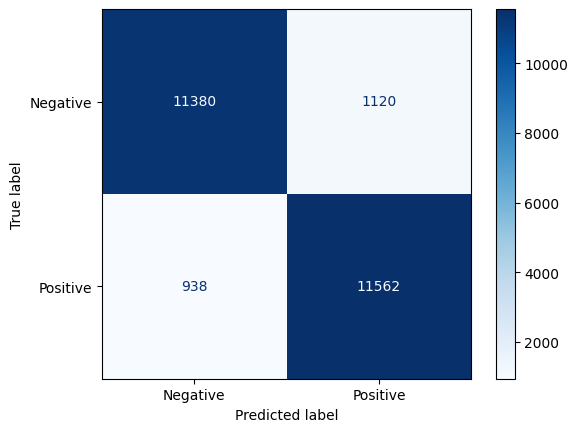

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

preds = trainer.predict(tokenized['test'])
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Negative','Positive']).plot(cmap='Blues')


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.086000,0.484741,0.905760
2,0.140600,0.444439,0.891200


Epoch,Training Loss,Validation Loss,Accuracy
1,0.086000,0.484741,0.905760
2,0.140600,0.444439,0.891200


In [38]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.6125510931015015, 'eval_accuracy': 0.91184, 'eval_runtime': 79.2568, 'eval_samples_per_second': 315.43, 'eval_steps_per_second': 19.721, 'epoch': 4.0}


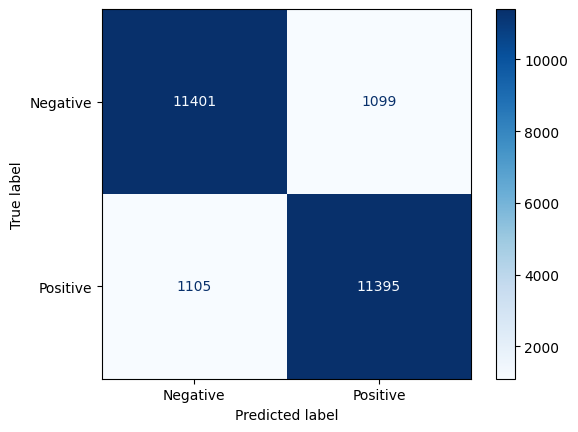

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

preds = trainer.predict(tokenized['test'])
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Negative','Positive']).plot(cmap='Blues')
